
### Let us look at how we can implement text classification with Tensorflow https://www.tensorflow.org/ TensorFlow is an end-to-end open source platform for machine learning.

The dataset is from Amazon Review Data (2018) https://nijianmo.github.io/amazon/index.html. I here look at Cell Phones and Accessories review dataset for this experiment. I have pre-processed this dataset. Please refer to the Preprocessing folder.


Let us perform sentiment classification by considering reviews which have rating 3(3,4,5) and above as having positive sentiment and reviews having ratings below 3(1,2) as negative sentiment. Let us develop a LSTM based classfication model for sentiment classification on review data.

In [2]:
pip install --upgrade pip

  Using cached pip-21.3.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.2.2
    Uninstalling pip-21.2.2:
      Successfully uninstalled pip-21.2.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow

     |████████████████████████████████| 207.0 MB 518 kB/s             
     |████████████████████████████████| 4.1 MB 12.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.3 MB 11.0 MB/s            
     |████████████████████████████████| 42 kB 3.3 MB/s             
     |████████████████████████████████| 1.6 MB 13.2 MB/s            
     |████████████████████████████████| 57 kB 11.4 MB/s            
     |████████████████████████████████| 12.2 MB 718 kB/s            
     |████████████████████████████████| 1.0 MB 13.3 MB/s            
     |████████████████████████████████| 126 kB 12.2 MB/s            
     |████████████████████████████████| 5.8 MB 12.1 MB/s            
     |████████████████████████████████| 65 kB 8.4 MB/s             
     |████████████████████████████████| 463 kB 11.7 MB/s            
     |████████████████████████████████| 3.1 MB 13.5 MB/s            
     |████████████████████████████████| 3.5 MB 9.3 MB/s        

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

In [7]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.7.0


In [8]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


****
### Let us define methods to pre-process the review data
****

In [9]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

***

### Let us pre-process the data

***

In [11]:
review_data= pd.read_csv("CellPhonesRating.csv")
print(review_data.head(10))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

   Unnamed: 0  rating  verified   reviewTime      reviewerID   productID  \
0           0     5.0     False  11 19, 2014  A1GG51FWU0XQYH  098949232X   
1           1     5.0     False  11 19, 2014   AVFIDS9RK38E0  098949232X   
2           2     5.0     False  11 19, 2014  A2S4AVR5SJ7KMI  098949232X   
3           3     5.0     False  11 19, 2014   AEMMMVOR9BFLI  098949232X   
4           4     5.0     False  11 19, 2014  A2DZXMBTY7KLYP  098949232X   
5           5     5.0     False  11 19, 2014   AUD367H6I25FX  098949232X   
6           6     5.0     False  11 19, 2014  A3K6KUWAZ6SWHE  098949232X   
7           7     5.0     False  11 19, 2014  A1FPEO0ME9G4VY  098949232X   
8           8     5.0      True  02 20, 2015  A20AOY7UXJA710  098949232X   
9           9     5.0      True  02 13, 2015  A222LHL23AH0GK  098949232X   

                                          reviewText  \
0   If your into space this is the Calendar for you.   
1                                  Awesome pictures

In [12]:
review_data.dropna(axis = 0, how ='any',inplace=True) 





#review_data['reviewText'] = review_data['reviewText'].apply(remove_url)
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))


#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Dataset --------
5.0    4571346
4.0    1356860
1.0    1302427
3.0     812672
2.0     631658
Name: rating, dtype: int64
8674963
-------------------------
Train Max Sentence Length :4303


In [13]:
review_data['Num_words_text'].describe()

count    8.674963e+06
mean     3.278012e+01
std      4.853429e+01
min      0.000000e+00
25%      9.000000e+00
50%      1.900000e+01
75%      3.700000e+01
max      4.303000e+03
Name: Num_words_text, dtype: float64

<AxesSubplot:xlabel='Num_words_text'>

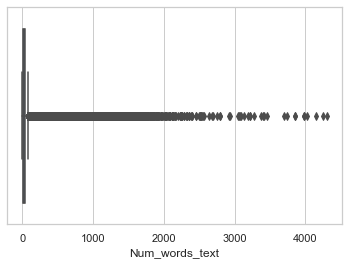

In [14]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

***
### Let us create a dataset having reviews of 100 words or less
***

In [15]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
3751739
No of Long reviews
486354


In [16]:
print(df_short_reviews['Num_words_text'].max())

99


In [17]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0

***
### Let us create our train and test datasets
***

In [18]:
#df_short_reviews['rating'].value_counts()
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())

2732274
5.0    1354842
4.0     471188
1.0     404503
3.0     278057
2.0     223684
Name: rating, dtype: int64
Train data
1    2104087
0     628187
Name: sentiment, dtype: int64
7149702
5.0    3866606
4.0    1085293
1.0    1058607
3.0     639317
2.0     499879
Name: rating, dtype: int64
Test data
1    5591216
0    1558486
Name: sentiment, dtype: int64


In [19]:
train_data['sentiment'].value_counts()

1    2104087
0     628187
Name: sentiment, dtype: int64

***
### Let us split the training data into train and validation datasets
### Let us convert our training,validation and test data into the format accepted by tensorflow
***

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:1366137
Class distributionCounter({1: 1052044, 0: 314093})
Valid data len:1366137
Class distributionCounter({1: 1052043, 0: 314094})


***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [21]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[32303, 108, 31, 14]]


***
### Let us create our train,validation and test tensorflow datasets
***

In [22]:


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

Train data len:1366137
Class distributionCounter({1: 1052044, 0: 314093})
Validation data len:1366137
Class distributionCounter({1: 1052043, 0: 314094})
Test data len:7149702
Class distributionCounter({1: 5591216, 0: 1558486})


In [23]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[   44   350  1309     5     6     2 18891   100  4006     5     6  3625
   271     5     6  4071    18   518    75    16    24    67   305   757
   149 22760   257    57    30    26    14  1129     2  1458  1309     5
   166    14  2682     6   108    14    37   735   812    92   458    30
     6   390   128   721  1314     6   229 41777     1    10    50    29
  8337     2     5   135    53  2047   602    10    11    62    69    14
   166   454    34   916   258     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[  38    4    7   78   16  312    3   16  356   83   78   53  482   41
 1839   37  186  366  949   39 4202  460    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

****
### Let us create a simple LSTM based sentiment classification  model  
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture[1] used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition,[2] speech recognition[3][4] and anomaly detection in network traffic or IDSs (intrusion detection systems).
https://en.wikipedia.org/wiki/Long_short-term_memory

For futher reading :https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

****



In [31]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1600px-The_LSTM_cell.png")

****
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
****

In [32]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4


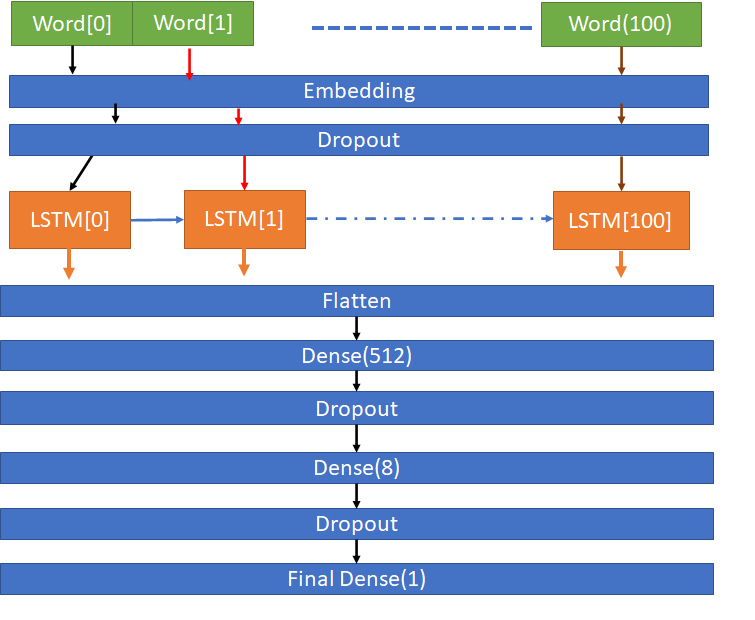

In [33]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAvMAAAJsCAIAAAD/V7sWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAE/YSURBVHhe7d0NdFzVfe/949i41shgasmSBYyQrTQWJDKSWkKQC0E3I8B9SK+hi5qg4CscP89SyMuCK2eJtPdBEWu1zaxYF1ouiboWFYrBBCdNSbPSGiJxUUMtSGiliScBObdCsgewNZb8mBeNVAPRs/fZe0bzotGM3kZn9nw/6yz57DNnzhmNR3N+89/7nFk1PT1tAQAAGCF1svnSI7e+NXZSN7CcLrhg7fvvn9cNLKdLCksf/cozugEAMEjqZHNr6++XXbVJN7CcRn55hqc6M8RT/Uzbv+sGgCXF52GzOf+TIcnGQUg2GUOyAZYPRw2zOf/98yP6XwAAgOxHsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZYDlddPf9tz37UP3dl+i2VHPNsw+Jhfa09zK9MJXP7A3f5aHbHvuji/RSAHAY+80q9k0vMy658rH5vKmaLCeTjamH28ta5SOZ7S9KveLnuumaz+j2stu6WT5Rb4y++ZL/zZd876iFEVtrrpn18Qz7BuX6o+/qNgCspNmOI8IlV36u0rL8rz3+ll6QOW+9+j2/ZVVemrE3c+da/mST5YfbSy67e2/9THy5/5rPRD1ahx1u3/hX8bK2LtxRFZ+xtlZdaoe1C0s32+1omy+UN/nffF41MyXw05+3df68rT862Vz0mb31375LPdR4r/e/Ktf/aXwSApADsuM4Iqg325d8b+h2lGQf27Q5jzVaqnWe971pWZd+jqr28iebbD7cij+Mr31yd+WFOvGMWpcVX/q1r838CTntcGu/rK3Ltl+2VbXDtmy+UM1cWxUfGz5Tdan4OevfYUbJ9yDP18RTLZ5nvQgAlGw5jlz06e3izfbNf+3X7bC5PrZJqY41Ujrr9Mv3z8RDQM7JQG9U1h5uL7p7T4V4ZC890bPvm3bi+eY/3NP9rvgT2r3nSoe+buyXtVV84RbV1C77w0rLGn1XPpvxhcqLSovEz3dPnlbNFfOZmysuG33z8Lf+YV+nfLUAQLTsOI5cctmO4oQslfpjWzrHmjSPR3YELL7004n1npySiXE2WXq4rblit3iNjg4+EdVj8vo///zwqJNfN++cFA/PuvQPa1TTdslFbvF6P/baUXnTRaUxHwLsv8PRN/8l0iVsVzvtkqk93V/fWhP3IcnuXb5f/C1dFK6L1t8d3t3WmitbZd+zqpReOUs1NYnnn+2555s/X4GeaQBZIRuOI6qA9MbpmCp+6o9t6Rxr0j4eDZ+WcSexuJVbMjKCOCsPt3rkzbE3Xldt7Z2TQfHTsa+bd/7lmBz047YfvKL+2AKn37Bvinnk+u8w8juGq53i71BWO/3viveRa+/yzDak+sK77veINcV7ipgvVctqrvn2XRXXFlvyo4m8b8XXvuaRf43peOud2OcZAKJlwXFEFZACsckm5ce2dI416R+PXrf3flnUISAXZSbZZOPhdtbXqGAnYud63fem+PgSXbO1fxHZ75vkpneP6hHTl7V+TVc7b1bVzs7um7/1C/k5qfKTrdHvJkLxpdcWvys+hdz8ze6b7/uHNtmpfFnrXXbt9wnx0UTed999Pd+SXeMAsHjOP44kqRKl+tiWzrFmHsej03YFq+iiuG673JKRZJONh1v1Gk3KuYn4rTfkx5eZ+qSu1g7P3BQp59o3idSvPkzUXHqt+On/Rcz5Sm+90faErKAm9mG/9ER3zKcQdXdZLFVt4Z3nO3tksRQAFs3xx5GLSmXWCb+jpiudY818jkdvvRMQP+O77XJMZpJN1h5uZ+mjVbU+B9P1SX2mgP0MhD+4qJvC5Vy7kBsZ7KarnYm/3eyfAOIH/ycplgLAEjH5Y1s6x5psPB6tkAwlm2w93M52JqHjqZMI1J+r/QxEPrjE3mRXayMnDiSrdmo5/gkAwMpz9nFE7XSB0jnWZOXxaGVkKtlk3eFW/Z3MIukfiXOokwjkmQLq4gpR1VF1k/xLjr/uguqvje7DjqE+GAHAynH0cUR1A81bOseabD4erYg1+t/lJ46pd116rTzcvlNqH1NjDrfipmSH28oL7cPtbP9zy3+4Tdx1ij8SR3jjX/2fvLbyotIau9835uIK8vyCa2U59524m+yq5oV2f23Mr6beI6xgikFwye6OpVHffFTPJdfdvkPPsf5sWH9ui1k/Y7LzOJKOdI412Xk8WgkZq9nYh1vxM+nh1u49jb9JdSImDtedz+F2gaN91SeAhPuq7tuMXiNhAewCzIU7brxCVmtjXvTq/IILd+xJuEmVc+R4uqhf+ZLL7qoXfznvHn5Wf/pJSt/9iqgLYl509/1pn/UNAKk5+TiizkuPPfk8Dekca+ZxPFKdYjleZc9gssm2w+3MrlVb2vpH8hGuzLedzYc+U6BYPkuRaq2S/KbweLq7PM/ef03rXjHVP/u1T8r/ke50rqH3xhPqgphfu+0x+76PPSSe53flGZLpqLnS3qOYrrD7qi/6nG5emcnvfAHgcA4+jsQOA0pfOsea9I9H6jslUsU1w2Uy2WTb4Taya/nFY2LXj91/27flX8Kb3+pM9Zew4tSZAsJoVLVWeeudyE0z17BS+n8uz4QcfVee91gpJvkFJYef6Nn3zzH/Wcm8/s/d9zxh/z/a97X8g/fc1/1EesWtrZvVHuUd5Z+ldaG9ETnN9wMQAIM5+Thip66E0YqpP7alc6xJ93jEyBtp1fT0tJ5N4tbW3y+7apNuLFI4544Ofuubr0ZVEYXL7r7/k+qme775anzYvOSyVhHD5etVEofboz997fHo8/f0lt/81n0/j92stLXmmj8LfxXZG/7Bv+x81fqj+m/XW4e/NXNq31a55MKXnlBXL5ixtebKu26UF2iyvfuG/7W/7EwYIV9zzbN3XfpGd7oJIKmRX55ZsqfauZI91WlZwqf6mbZ/1w0AS2opjxqJnHscsa8HWHGZ/xc3R6UN9Y6nGzHejTkGpXGsSWMd9SvEbHnpOf/9M7PJxrmccrjlqZ4byQZwvtw4aszmstaHPnmtNXs2ygj7Acwa7JaQ898/M9kbBUS4b7TrsfHf25KU/NIWsf6N6a4PABmn+q1iv9wqk2Ku8ZPDSDbRONxmgD7RQA3lifqel7ltqaqQ64cryQDgQGqsj7qsTsZddPeNl1rWm99bZEnbACQbhcNt5vT//Ob7/kFPaY/Ffr4zfJf7/mGxXVEAsEzeevV7/rgTqTJFfb15zJnwuYpxNg6SG+NsHIFxNsDy4ahhNsbZAAAAZA7JBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwR+prEN/5l9dN/mdIN7LEyV+Oh86dv2Dd6vJrivSibLBqVer/DiyJvN9xPfVnL+oGgCXFNYjN5vxrEJt5KK2rq+vt7S0rKxseHtaLAAAZkY2fhxes8PQ7ayff/3DNR0bdv6sXmc75nwxJNgAALNCTX/2jEwMvXlxy+Ze+/yu9CCuNcTaYv64u6xvfsB5+WDcBAHAMkg3m77vftdrarL/+a90EAMAxSDYAAMAcJBsAAGAOkg0AADAHyQYAAJiDZAMAAMxBsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOYxKNoODg9+wjYyMiOa5c+dU8+WXX1YrAAAAs62anp7Ws9lvampqy5Ytp0+f1m3bunXrhoeHN2/erNtYvLo6q7fXKiuzhof1EgDIJeMnfvPr5/9ezPiffercqRPr1m+4+vZ7RLP8mvpLP361vQpWjFE1GxFiWlpadCOsqamJWAMAWEIbSkoH/rHzxcf/SsQa0Zx6720x/9Khh8RytQJWkGnjbOJyzKxZBwCAxVizdt21DffpRljNri+s31isG1g5piWbuChDwQYAsBzicsysWQcrwsBzoyJphoINAGCZxEUZCjbOYWCyiQQaCjYAgOUTSTMUbBzFwGQjiExTVlZGwWaJ+XzWqlVy6u2VzZER3fzRj+ybASC3RAINBRtHMeqs72gjIyMi3OgGlsqtt8bnmKoqa2BAzwNAjvng/NTffv4P/lvH8yQb55gr2fzxVw6efOusbgCWte3tNw8/f0A3bPd9au8Ll1TqBgDknvzfnpv4yMW6katKL9n440f26MZKmyvZVP3Jw5vKuOIQYnzjx1/f8R8vqvmhTb/XdNfjah4AkLPOjLzi++G9urHSzBxng+XzxLV79VzsPAAATkCywfwMbfq9ox+9LnoGAADnINlg3lSphoINAMCBSDaYt6FNvydiDQUbAIADkWywEAcp2AAAHIlkA+SMktLO9h3djYW6ueTU9ltKy3U7iVlXK8lPcS8ASA/JBnCUwjZx1J9taqvRaxiopqJ7f1VHe4VHtwFg4Ug2gAOFAv7xvtjpxVP6NmMFQ8N6DgAWjmQDONDkU12DrbFTj8HJpn+wvvlovffkkG4DwMKRbAAAgDn4dgXAUQrb2rfVWuPe5sEevSRBSWnnfrfV49vry9t3k3t3pUsuDI57D9p1nZLCtj3baovksoA/8BddUYUQ+45u//H6rsl9jR8L3zHU1/2b1v4Je40Z5TWle+rdajuWFerrCRw8MhZbU8n37HTf6Slwy/lQoCfwFz7Xn4vtBwNNMdWXNFabeWBjakGy3/HwwcHH4mtX+TO/S7TorQFYZny7AoBFK3Z37t+2u9KSo3CCllVU0LK/Yt/Oiu79IhiFxMJA0HJXujsSz1QSd2yvEne0h/KErCJXbUNV5858fautfGd1R4OINXq4T8By1Xq2xW3K01jVIvOK3Jd4AG6xgkgn+sYZaa42u5jfUTzUgt37q/eV6BttIgiK38UVCNqPUzwPktzX4WOTqgEg11CzARxF1WxEpJgM6CVS4NjgY/16Xlc4xIz/eFOXqqPk72up2q3qND2+vUdUAUZv6vCBAV3nmOWO9nlJDQVWdJVIrRZTesmXAUUkjENHW9XDmOVehW0yVFlW9B3TXC1JzSbuocq85XFFF2PUkqhfWT0PUb8ygIygZgNgbi53ZUFt9FQcU1ORRDKIpBNr4oVjIfmv/3j4GC+MHewRC13umCJH3B0tqz9wWJY6Cq4Ln1XuuUlGir7u6B6liZ7nAiJp1W7X18LxbBd5RaSowEyX2amx1gNynWhprpZU7EMd8o3LOxa7IqWjLcUuWaHxRX5l9Twk/MoAcgnJBnCgcW/zUXm6UHiKyitho6Go5GENjcrOl4D9M447LhXF3lGkgZFR+U94tfyyYru5vaKtMWq6yR4oo1OFWic6UswqzdWSi3uop0LpRiIAOYxkA+S64VG73hMrvmiUOETXAexH7qqtikS3/LrtsooToCsKyGEkGyDX2X06cUKHD8QUjfQUc9LTylP9U25PVWeLLCx1qsFG/gCDbIBcRrIBcpzufgqMqj4j1Tk191CVdNYR0lxtwfL37XHbZ13J06ZqKwvcRaG+HjniWN8OICeRbIAcU7mtu7EwMgi3vMYt6xzBwMHwuVc9x8bFz9r6+NPFy2tKPeGMMss6kbOZoqS52kLlueUjn3yxa2CvrioNtMZfdAdAziHZAA6Ud2f06F17ir2Oy8IFgqFA5baO9mq52ZbqDnlWduyZUP2DXr9lFbk72neoXp62xuru9h0dDe7rIo9BnVEl19Hb6ZYnittX1omW5moLNNZ6aDxQVNAS9b2hnS3VnY0zCQxADiLZAA6UcNa3mGbGyS7Osd/sPXC8L+iS2yxyyQv7HghfpSasp+tokwgNQctt9/LUVoo8NO494ItabeIxr8/rtwfwyu1YfT2+em/i6dxprrZAnu32GVv2ZfrUZD917pb4C/oByCFcqQ9AdlKXAUz4FoWEy/cBWHZcqQ8AlkZC+SdfneoVHhANIOdQswGQpdTXRwihPr+6RGGeu9Jl90/FfSsngOVFzQYAFm+s9YAcxBNQY4bk5JJfXX7IR6wBchk1GwAAsCjUbMz31q//+fWXOk/2f1+3AQAm2jzWXfbmk5edfka34QAkm2Vx6tUjItkE+n+g2wAAE6lk4x79R92GA5BsAACAOUg2AADAHHONIK79/LdDk+d1A/Mx9OKj7535j7WujVfc/P/qRQAA49xwrnPT+eHQ6t/9p4L/rhflJFfe2r4n79GNlTZXssGC1dXV9fb2lpWVDQ8P60VYVl1d1siIdfHF1r1OGZwPIBc8+dU/OjHw4sUll3/p+7/Si7DS6I2CEb77Xautzfrrv9ZNAECuItkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADAHyWYpnT59utd27tw50ZyamlLNkZERtQIAAFhWXM9mKYlks2XLFhFodDtsYGCgqqpKN7Ac6uqs3l6rrMziAkIAlt+bv35l6OfdYsb/7FPnTp1Yt37D1bfL69SVX1N/6cevtlfBiiHZLLH77rvv4Ycf1g3brl27nnmGr4FdHqdPW4ODcua++yyfz9q82fre92RTRBwxAcDyeO/s6KO3f+KD8zGfY9esXfelH/xq/cZi3cYKIdksscSyDQWbZSSSzZYtVkKRTDzpFs85gOXU/cj9v/j+o2pe+eSffqn+K9/UDawcxtkssc2bNzc1NemGXbAh1iyjzZutqGdb27WLWANguV3bcN+atet0wy7YiCW6gRVFsll6LS0t69bpl3tra6uawXJpabHCz7bGcw5g+a3fWFyz6wu6YVlinn4ohyDZLL1I2YaCTSbElW0o2ADIlEjZhoKNo5BsloUq21CwyZDosg3POYBMiZRtKNg4CslmWWzevPmZZ56hYJMhkbINBRsAmXVtw33r1m+gYOMoc50b9cdfOXjyrbO6AThY4dS7//Tcg3tuuPf4hkv1IgDIiIs/OHVuTYlu5KrSSzb++JE9urHS5ko2VX/y8KYyrjiE7HD1yM9fKbtGNwAAGXRm5BXfD+/VjZVGbxQMQawBAAgkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5uCsbyBLFba1b6vV81ogGAocCxw8MjakFwBAJnDWN4ClEgr4x/vUFAy5i1y1nm0d7dVtNfn69iyWv69lR3d79b5cvwQagPkh2QBZbfKprsFWNXkH6pt93p6QZblqG6raavQaAJBTSDaASSZ6jgw0yXBj1daXlqtlAJBLGGcDZCk1zmbc2zzYo5dE6CE4fYeOtvbbC0pKO/e7rR7fXl9B2x53bZFlBQNe70l1x/Ka0j31BbVFLrtlBYLjTx0c7DmlWrbI3Y9Y+xo/trtSrRnqO/Sb1v4Je35G6q3VVHQ3FFj+4/VdY3qJYO/CHQw0eU8OWZancUdLpb4lYubXAeAwjLMBsKzGXvTLf9zFsaNtit0iPYhYEwhaVjh5lO+s7mgQC116vE7QchcVtOzfMUtnlrh7e9XuSsteU/d5de6M2cU8tjan4WMBcfeAPR8eSBR4MToeAUASJBvAQMOjskPKXZynmoq7skAWRZqP7vUerVeVnpqKDo+IOOPeA0f36sE6R5sOjYtbahsqPPa9IuTd/cebmgfsNQfq7dXcHvfMavPZ2tyG+k+2dgVEMJKVoefUQKKTMYUfAEiCZAPkjnGv3dcT4dleIH72HYrpLRrqH/TKkk/BdXGFFpGKuqLOJ+8PHJbJY2a1+W0NAJYHyQbIGf6x2BE5+WXF4mcokFALCZd8YjuzRkOxl8mZGBmV/4RXm+fWAGB5kGwAA20plsNoAqOTqplEnrtI/JwcSdLLE9eZlUhFlrDFbg0AlgTJBjBP4XXyxKJQny/+xKVYk3IosZVXluRSeKmCkc5PYYvdGgAsCZINYJrynW75rQvB8ReSlE/CVHeSyx2fRfLrtquSz9zBSHU/RVZLe2unQvKkp2IXl9sBsBxINoBBSvI9jdX2CUqhwwdjBgvPqudY+MSlqDhSXuPebV/w5mDcxWMqt3U3FkbiSOJq6W5NJZuigrrIaiWFbfvdbt2ISBaVAGAuXKkPyFLhb8QM2kFBKHKFw0Ho8IGBx6ILNuo6eHEXx7NFrokXUNePKS6Q1/GL24K+jF4oIHcR6vNPWsV56lp8cVfPS2trM6uFAv7JgJVXW+mSv4XYePhKfYq8Oo6d0tQere4BrtQHOBNX6gOwdEQgUJPIE8Hxw4d8Tc2xsWZOPV3ykjOBoLxcTa2YikTaCHjjgpEyGth74Hhf0LJXE1lEXrcmLmqkubWeLp+3R0Qfl72a1ddzvMkb0PksytCRAa+6JKDc1GTiWVcAkIiaDYBUkpd8AECgZgMAALAsSDYAAMAcJBsAAGAOkg2AVE6d3Nt8lEE2ALICyQYAAJiDZAMAAMxBsgEAAOaY63o2tZ//dmjyvG4AAADMxpW3tu/Je3Rjpc2VbHLN6dOnq6urxc+LL774tdde27x5s74B2aiuzurttcrKrOFhvQQAltqxI4fOnTqxbv2GT/7pl/QirDR6o2Z8/etfF7FGzDQ1NRFrAAApiWTz4uN/9crff0e34QAkG+3ZZ5/t6uoSMxUVFa2trWohAADILiQbaWpq6otf/KKa/853vrNu3To1DwAAsgvJRvr6178+MjIiZhobG2+44Qa1EAAAZB2SjeXz+R5++GExs3nz5oceekgtBAAA2SjXk83U1NTdd9+t5kWsufjii9U8AADIRrmebB5++GGfzydmdu3adccdd6iFAAAgS+V0shkcHGxraxMz69at+853OGcPAICsl9PJ5otf/OLU1JSYeeihh7iADQAABsjdZNPV1dXb2ytmPvWpTzU1NamFAAAgq+Vosjl9+vR9990nZtatW/f444+rhQAAINvlaLIRsebcuXNipqWlpaKiQi0EAADZLheTzY9+9KOnn35azIhMc//996uFAADAADmXbM6dOxf5IoXHH3+cL1IAAMAkOZdsor/Q+1Of+pRaCAAAzJBbyebll1/u6OgQM3yRAgAARsqhZBP9RQp8oTcAAEbKoWTzzW9+c3BwUMzccccdu3btUgsBAIBJciXZ+Hw+r9crZi6++GL6oQAAMFWuJBu+SAEAgFyQE8mmo6Pj5ZdfFjM33HBDY2OjWggAAMxjfrLhixQAAMgd5iebu+++W/VDtba2lpWVqYUAAMBIhiebp59++tlnnxUzVVVV9957r1oIAABMZXKyOXfunOqHEvgiBQAAcoGByeYb3/hGV1eXmBGxRn2Rwv33319VVWXfCNOJ//HeXjnZ3+VuTU3p5siIfTMAwHCrpqen9awpPve5zz399NM33HBDrzieWVZZWdlrr71GwSZXiGSzZYsMNHEGBizSLYAlMn7iN79+/u/FjP/Zp86dOrFu/Yarb79HNMuvqb/041fbq2DFGJhs6urqVKZRjhw5cvPNN+sGcsF991kPP6znlV27rGee0fMAsGgfnJ969PZPvHd2VLdta9au+9IPfrV+Y7FuY4UY2Bs1Etvv0NbW5vP5dAO5oKXFiivRtbbqGQBYCiLEXNugx3FG1Oz6ArHGCQxMNmpsTcTLL78cuQAxcsLmzVZTk54Xdu2iHwrAkovLMbNmHawI05KNiDXRIWbz5s2PP/74Sy+9xDib3BJdtqFgA2AZxEUZCjbOYWCy0XOWde+997722mt8nUIuipRtKNgAWDaRNEPBxlHMTDaf+tSnBgYGHnrooYsvvlgtR85RZRsKNgCWTSTQULBxFNPOjXr22WdFuKFOs+Se3/9f3jmVZZeEKT41OVqSpxvZ46KSss8c+N+6AcDZPjg/9bef/4P/1vE8ycY55ko22Xgwy1LOP5g907D10+UUwDLhX4bO3Xrodd0ADGXS8eX9D397wWpDOkDM+GQ1V7LhYJYxzj+Y8WLIGJINcgFvKc5kxvuPgWd9AwCAnEWyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwB8kGAACYg2QDAADMQbIBAADmINkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADAHyQYAAJiDZAMAAMxBsgG0tXf0b3xQT+sr9cJUblkfvsvGB59xFeulAICVsmp6elrPJnimYeunyy/WDXOJ49n6K/X8+R/UvOfX83MSx7MH1+r5E1OP3hoa1Y2F+Zehc7ceel03HGnRLwb1jP3svQfuPa+XxKlYe8df5V15+Wq78eGZn73f2xHyD4rlrq88tW6TvTSJD39259s9Ys1bXF950F7zxPkffP09ed9ZiR09pf7Hw3dU1I5OfPjqiQ/FK+GFe8/H/J/Kh7f+ysutVx84+/RP9DKpYq2naW2htXrT9as3LcErQXD+iwFYvBw5vmQdM95/lrtmoz7RPhwOAYnEAeOZDeFPvRu+8rCrskItd31FL0w2bfCoNcXxTC15Zr2+76zEjuLuqFSssY+FH776s/NiCqqF0prKr66feQzPbLjjljX6FuE/zv9Mrv/hGd3G4ojXiUgbl68+c0L+L7x6QgSFdbc/pQonH5w58eHMZK8uo0/UwnCY+IgOQJevvb0p6UuusikSZGdzYvLpe997OjbWFN+y/ivy4elmjMHzPXL9SV4JQM5bUN13qVA/nrGyvVHOPZ6t8Txz0e2Na+UneDvBWJevvvLBi77y1XC44Xi2lNZ4viD/41594Owjt4pn9b2nbz376ANTZ07YNw6ef/rWtx8JT9/v+lAsO9M1EVki7hJTnhH/X+Ln9WuTvK2s/fj1sqjzqtp4auKVsPFLD4pXgngZ6EUAVkAWf062yYcn73XHLXpBrDk/S2t83k7TSiYb5x7Pir+af734gP6z9x699W078bz9wJ1T4uWyqTE/5nWMJVGx9gpZDjn/66hentGfhOR/sW7Ny/lfywiy9uOzvX0UfzVPBNwzL5wf0wtSuWXd9Zd/+GrXOw/c+t6v9SIA6Xtv8gMx6cYyyt66r5Tqs7TE5+30rWCyce7xbG1d42o5CKMj6qU5GLLT1eorbkzM0SbJyHtQnMEP7D/F1cVLlBr9HTKGXvmFxHrsmso68T97vvdvfqsXpPSTqUfvfPvpv8n8kwKYYeitibv+4t8PPndyWd9bsrvum85naT5vz8cKJhvHHs90RfH9uCGoo6/Lv4dNdWuN7r/86t8c++sfDo2e/U/dzgiVSldf/1dzVoDTN3j+NfGmc/kF8VuTBRj5tjWf6PzBaOzLAMA8iUzzxE8Dy5lvsrvum85n6Vz+vL0Ay31u1C1znRFT+fDG2+3wO9eZLLbir274UuPqM13vPJL46XlmF7/1PHOReA3FnPAizL2COiMm+hEme8z63Jno81/s86qMOjdKvPucPjslZm66uviuG93FG39HLV/uc6PW3vFMuFQrXw9T/sHZ3//SeyWcV6vF7c5+van/fVnXTf1KiKVervHnRmlL9UoQxIsh/96Xf/pv8b300b74x1vKL83XjSjf+cdh8RF544Vr/+zzH9OLopx99/xfPvkb3ZjNjX9QdOPVRboR5aevBNXjmXu/upEg5eNJud9keB4UJz8PIsoMvTnznKzPW3PrdSW3XX9J976PzfMtZa73EPsPMO5sxyTSeg/pWJPwbq+ot47zP6iZKk73PWRNcYX+gDT7e8gsRxabejBqeTrr6EWLfC/i3KhF89/73qvys/Xa259SI7YWGTw/8L8gA+z1sf2jlR7RlFFXt1Mp3iqicXKXf2SWv/QlJt4Lfjn09oKnFwbOiM9GC5sin6iee2X083/xb994fDD6XWn5nH/61nd+0HVelvHk6+GiFCP4Uhn9m8n4enKF6wYZo+NLcY4kwuUv/+PtOab3pmYPfuJwIm597cS7uh3r/fenozeSOKlQmyjyeObeb7Ip5eNJud9kE8+Dmpz8PMS9gUTqN6+v+329aClkc933o/bgnhMfxAeR//it3a1hS2cdzFjZc6McfDw783pC15XuPlsOg3nX1zcfjUy3/o+f7//2rxY8ic9h4r1jYVNcrfjor8ab/qfvwNP/8eGqC/SiZfOB/2/ee6TmnUcfiLweYs87mB9dT74hPLyu+MYLxFvDq3+3sM8xAJbKVR/d8I27K7ZO/btuLwlnfk5ORzqfpR3weTu7rGhvVJQ1xbes+9MH19rj0mepKKbZByFaqtwXWVPdMVz9S6sPYtaODJsqeEZfzW+p+iD+9q3t/3vD/60bTrKI0nGcdF8JivqfksPl4tZP/5UQW+ON+79zeG8UV+qDMX459Lb4uKXmRaa560b3VeUbxPz8jy+p30PWVH513Q2N6jii+rVnGeeQ9ntIwht+zFvKkr2HJH88Mw8gmMY6S3RUojdqKX0w+hP5ef1ncrR5fEyeFzWOODzOV426ihlWlpIaKTwLPbL4t3P1dy9Q4fsnxB/8gqev3fF7B+75xIKnw9+4urt9h5rEW496SGvXfEQEmif+/Pf33FQq8o1amDEf9Pyd/dZw+ZqFj9fW9eR1dbeI9w570F/X1HxqyACWinhjke82X/yEijXLJIvrvpu2pj4Yp7MObM56opx0PEt8DMl6OpdA4QcnRIBY8HTj1UXi/WLB08YLY5KkzjT/4/e/+F+3ZD7TLCFVT7au9Ljsk+M+fO2nCR/RACyvzb+7LgOZJpqDPienI53P0ivxeTurGRgBF308+4l9MYOEnku7h3W28TdGqf34xs6WGpFp4uLOMir+atTVQpWKtXc8aD/bL8Rc7Wq+wuOu1KC/ybguTgDLr3jj72Qs00TLtrpvOp+lM/p5O6utXLJx8PFMFyFvj76MtxqJLC+KY/bn/tuuvyRypvcyuH79V57ZED3dYV8d3L5aqLxeuL1wo7yWqFh6Yur7i3221X+l9GrP7D3fqaz1PLz+Dnu6QbycxEP9gm56Zr9EOgBjZKTum85n6Zz+vL0AmUk22XY8k8PsxT/Xr5dfzCEOY89sePAp+SXSrz6wsOs+Ycamy1fHTFtFEn370Qem7G/YVreK18CHrz7wzgNLMBrX8qsXwImpFxZWQ65Yc8X1a6+0J/nA5CPUzSu2ZnFHHWCSLK/7pvNZOpc/by9AZs6NSqDGeBff4qr7wgVXXi6ysE0cz/5u4umfzPKflPZo9jC1MH58+HxGs1es9TTlXX+9fmxnTpzvnWWY/VKdEeP84ehL8WJwuFTnNcxpqV4JAudGIRcs9Nwo+W4cM+jkzN9NvLA1XxwgdFPean9AEmb7k5zv0USd0CTEntOU/tFkrefhtYX2nPhcJB6YOJqor30Y63mvR29QneJkHwTF4798tTosxu4xnXUEzo0Slrtm85P3Hqg5mzipl9ToT0JP3/r2zPJb35411gjiY33kXvHULuKORmph/H/tBz23ih1FvRDnIL9dbOaxxX+xCABgJcQUfcVkQt33/NN3vvcz9SWX4ib7ez1/cGdcZElnHSjLXbNxPkd8Uqdm4wDqlaA+D1nnX4j9qt6kZG1PfCBbven61bNdi30BqNkgF5j4lrKoo8lSoWYjGHhu1IJcnmcPC0372y7F8UyunyfHpcMM6hrT6vPQ9WvTvabnR9deL9dfzSsBAJyBZMPxDNr5p8Odjw/MXNAzlej+1qUofQPIbvP9nLxU+Lw9g2TD8QwAsHgL+5y8VPi8PYNkAwDAEljQ5+SlwuftGSQbAABgDpINAAAwB8kGAACYg2QDAADMQbIBAADmINkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADAHyQYAAJiDZAMAAMxBsgEAAOYg2QAAAHOQbAAAgDlWTU9P69kEP/lC5ftTE7rheJ8uv1jPWda/DJ3Tc1nignX5t/ydXzcciRdDxjj/xQAs3jMNW6P/TuEQ4g3z1kOv60bWmivZZJezD9ToOcva+GC/nkNO4sUAOFx2fVjKHWZ8siLZwEC8GAAgZzHOBgCAhRAfoiKTXgQHINkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADAHyQYAAJiDZAMAAMxBsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQwx9crfT77wt2rSi2yRhZMvPq4XAQDMRbKBKT74z0iI0UtskYXT753ViwAA5lo1PT2tZ7Nc9JfIb3ywX88hZ0x/cP7t//l//fa9cd2OtWrN2g3//Z8+sr5AtwFgQUJH2j88fVzNvz/8b2pGuGDLH6gZ8T6Tf/tfqXmsiOyu2YhXVWTSi2zJlsNgIrusu65RNxL8ztW3E2sALN6asppZjy+Rhasv+4RehBWS3TWb977XfP61F3RjNmuvqFv/uXbdgOmSlW0o2ABYQu9853MfnNJlmzjifUa824j3HN3GSsjums26G/4fPZdEyhVgkmRlGwo2AJbQHEcW8RZErFlx2Z1s1pRsW3tFnW4kEDeJFXQDuSExxMzdSwUA85Xs4CLefMRbkG5g5WT9uVFzZWcKNrknMcdQsAGw5GY9vlCwcYisTzbJyjYUbHJWdJShYANgOSQeYijYOEfWJxth9uxMwSZXRacZCjYAlkncUYaCjXOYkGwSyzYUbHKcCjQUbAAsn+gDDQUbRzEh2Qjx2ZmCTW5TmYaCDYBlFTnWULBxFEOSTXTZhoINBBFrKNgAWFbqcEPBxmkMSTbCTHamYAO7bEPBBsByE0ccCjZOY873Rgnvfa9Z/OSiwwCAjJn+4DzJxlGMSjbqctd0RQEAkLOMSjYAACDHmTPOBgAAgGQDAADMQbIBAADmINkAAABzrPrsl7978q2zugUAALA4pZds/PEje3Qj41ZdddtDm8qu1i0AAIDFOTPyiu+H9+pGxtEbBQAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbIDeUlHa27+huLNRNADAUZ30DZihsa99Wq+ejjXubB3vEvyLZ7He7/cfru8bUDQCwTDjrG8DSCYYCsZNevkD5+1p2dLdX7yvR7bBkywFghZFsAJOMe70De2Omk7JgAwA5g2QDAADMwTgbwAxqnE14VE2iWcfZlOR7bvrYnZUut90KBMf7Dg4+dspuWJancUdLpZ6P6Dt09MXtsy9v7dfz5TWle+rdtUWqFerrCRw8MjakWoL9SKwe315f3r6b3LsrXXJhcPxw1K4BZDXG2QBYCTUiYVS1iGAhAo1/vC8YchcV7N4/M3Rm+FhALA/Y8wGxgpwCL55Kulwp31nd0SBiTUjdFLBctZ5tHS2l5fr2sGJ35/5tuystefdgyIrdNQAsGDUbwAyqZiPyxKTKHNqxQGv/hJxJrNnUVHRuDz313Mme6FDicVkxdZ38fS1Vu4tChw8MxBZUkixXewkGmrwnw0WafE+jyE9RRR21jpjxH2/q0rWc2XYNIFtRswGwVFzuyoLa6Gl7nr4lUf/g3q6ZWCMM+XQlZsE8N8nI0tcdiTXCRM9zAbHZ2u2xl9IR6SccawS962JXfGkHAOaJZAOYZNzbfLQ+ekpZAinJ99SUtjVWyOmmAjXgZqHyy4rlP+7t9tYik9psXGoZDUWlH8s6FVpkqAIAhWQD5Kz8fY3V3furWhrc4RqPPZh30eLrRku0WQBIB8kGyFGexip5XlIw4D0QLvAckN1GixY6HNlg9DQz8gYAlhHJBshNqucodPhgzFCbxZkYGRU/XW5OcQKwckg2AJR8Nf43VrKwMvvynmPj4mdtffw53uU1pR7iDoCMINkAuWnihWMhEU1276/ulON8qzvb5bnZiYZH5TdP1TZUy7HALdVtNWpxkuX9g16/ZRW5O9p3dLaoEcTV3e07Ohrc15FsAGQEyQbIUUNHBpp65JX07AG/8np93gPH+/SNM8RqXr/MQHIscNFkINx1lWx5T9fRpkPjgaDlLlLDh+Wljb0HfJErFAPAsuJKfQAAYClxpT4AAIClQbIBAADmINkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADDHqmsbHg1NntctAJjN2RO/OB86u/qCvE0f/bReBABJuPLW9j15j25k3Krp6Wk9CwBJ1NXV9fb2lpWVDQ8P60UA4Ej0RgEAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwB8kGAACYg2QDIKnTp0/32s6dOyeaU1NTqjkyMqJWAACnWTU9Pa1nASCWSDZbtmwRgUa3wwYGBqqqqnQDAJyEmg2ApDZv3tzU1KQbYbt27SLWAHAsajYA5pJYtqFgA8DJqNkAmEtc2YaCDQCHo2YDIIXosg0FGwAOR80GQAqRsg0FGwDOR80GQGqqbPPSSy+RbAA43KrPfvm7J986q1sAkMS7o4MXFlfoBgAkV3rJxh8/skc3Mm7VVbc9tKnsat0CAABYnDMjr/h+eK9uZBzjbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBsDiFba17+huKS3Xzcwp31nd3b6jrUY3AYBkA2Cxyne6ay2rr/vkkF6QOUNHAn2WVbu9ULcB5DzO+gYcorCtfZvIB9ECwVDgWODgkbHMJ4b5yN/XUrW7aNzbPNijl8zyu0jBQJM3Mf3kexo/1lLpsvzH67vG9LKIksJ9N7lrK11u1QyOH+4OPNY/oVqKp3FHS2Xo8IGBx07pJQBWFmd9A4gIBfzjfWoKhtxFrlrPto726raafH27A5UU1BZZln8sHGtmyGQWPY2G4mNNSWFbS5WMNbOqKe3cv223jDXy7nJJUcHuhqq4vqeeY+OW5aqtcvBTBCCDSDaAo0w+1TXYqibvQH2zz9sjjuiu2oTDuXOUVxW4LavvWEK5xX98r3cgZootycghMvu31RaFRIzTi+K5LH/Ae+BofbO8u3g2Dgfl0tqGCo99s9Y/1mdZ7u0FmR/lA8CBSDaAk030HBlokuHGqq1fgfG5aciv2+6SpaZ59wQV7vG4Av5AU/NA6zG9KF7/4N6ukz0zW5547GAgIGfyykrsBdpkQCSeooK6mIUAchTJBnA6NUjWKnLviS3blNeUtrXs6G5XU3XbzsKY6FNS2tm+o3Nnvhyq0ihPIJJTS8W+hMN/3HY6G2O2k2IvVp67SPycHJl3shk7eMAngstSDCGaGBkVP11ukg0Akg2QDcZe9Mt/3MUzQ0nKd1Z3NLhri/S4nIBlj8hJPO+62G0PVbHUwB05TmV/dUy4qamI3k5fUOxlZtRL6r2U2GN7g6Fh1YxW7G5rrLCnUk9NfvwDE4ntVMxA4LSo3SUEqeFRWdaKfn4A5CySDZAFwkfuPNW0Skr/3OOSpxo1D+y1B+XsbfZ5RfpJqOu4Kwvc/uOyx8ceuGN3bLl23xQ5Rzp/X32BZckTi9R25OCeyOlL6exFRY3EocFCkau2ssCe3C0NVfY4aH3Lgnm2i0drBXoCcaOVh0Ynxc+Z5wdADiPZANnHc5NbDtqNuX7MRM9zcgxK/JVdRC7pmjlpfMg3LsepFLsSKyiJ5rGXeGOtzb765qN6OiDykBoHHVsumq+aipZK8c/4U0fmX+wBkDNINkDWyS8rlv+4t6u+nvB0kzxHKT61xFVTToXsEbgRE491y1Omd++3h9fExI609lKetEwSFT5OTfR0DchiT0y5aJ5KCtsaZMGm71DkqjkAMAuSDZAFtthjXwJ2n0uEW/f1RKYkV4WZW/9g06FAX9DlrtzWsV8OMfbEllXm3ovqBkqHfdWZdMtFCQrb9stL/wV6fK39ehEAzIpkAzhf4XWyFybU54vuhQkdlhd6SZhmuchvCkP9J1u94T6jooKWmCHGS7YXbdYROSkUtrXoWLOXfigAqZBsAKdT38pkBcdf0CcELc9JznafkRpibG85vb2o7q00KjF68G/aNZ4wO9YUpYg1qlNs/hsHYCCSDeBgJfmexuoOj7wU3uGDM2US1bOTeO2+8prSuL6kVERuiOl+Ut1eSlp7UcmmyLVFNaX8fS3xXwdRrgf/xpWdUkor1gjh3joqOgD4RkzAKcLfIhkMD/ItCn8NpH1WdtzXPdpfAylnAsHxgCyu5KkRMH2HjuqRKCWlnfvd7vivmbT3MvPNlHqneiPF9jdARX1vZeq96K/DjH6EaomYCfX51cnYBfbV/EJ9hwaiR8l4dlZcZw9Storzaotc4hfvU0WX0bHWI/IxR+1dnvQeYzQQ9V0NiY8BwEpa2W/EXL35ipvzL75UtwCsGFfdTYUyyuRfsEFNdp549ke/+V/fPfn8e2qdGa/7An1j+VdtdrlFACoW0/uB4Dsd3/lN5/95X69x4Yb/WrthQ3D8CV90LLD3MvHOT46+/f/JZqjXP/k7F7pqt26QG8kPBfyvtzx6KlIcSr0X6/23Lyq8ZavrneFAr04V7/e/fvZU6ILL12/4xFZ5rw1ys6c7njje+X/UCkr+f/mTrTvtFdz5F9gLLrB34XKvn+yzH97WqtI/tKOPfkKip1V6Hamk5Mv14jc9/b+eDS8BsKJC595q2v0p3cg4ajYAFqemoruhwIovDmWQ/QAYXww4x8rWbBhnA2Bx+gPyK7grC2O+fzuD7LHJ8x3BA8BYJBsAizTxwrGQZRVct+gvT1iIktI7Ky3LH2CEDQCFZANgsdS3kSeeRZUB5VXymsh9x1aoIwyA8zDOBgAALCXG2QAAACwNkg0AADDHqmsbHg1NntctAJjN2RO/OB86u/qCvE0f/bReBABJuPLW9j15j25k3Krp6Wk9CwBJ1NXV9fb2lpWVDQ8P60UA4Ej0RgEAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAEmdPn2613bu3DnRnJqaUs2RkRG1AgA4Dd+ICSApkWy2bNkiAo1uhw0MDFRVVekGADgJNRsASW3evLmpqUk3wnbt2kWsAeBY1GwAzCWxbEPBBoCTUbMBMJe4sg0FGwAOR80GQArRZRsKNgAcjpoNgBQiZRsKNgCcj5oNgNRU2eall14i2QBwuFWf/fJ3T751VrcAIIl3RwcvLK7QDQBIrvSSjT9+ZI9uZNyqq257aFPZ1boFAACwOGdGXvH98F7dyDjG2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5uBKfUDWKWxr31ar57VAMBQ4Fjh4ZGxILwCAFcOV+gAsQCjgH+9TUzDkLnLVerZ1tFe31eTr27NY/r6WHd3t1ftKdBsA0keyAbLU5FNdg61q8g7UN/u8PSHLctU2VLXV6DUAIAeRbAAzTPQcGWiS4caqrS8tV8sAIPcwzgbIOmqczbi3ebBHL4nQQ3D6Dh1t7bcXlJR27ndbPb69voK2Pe7aIssKBrzek+qO5TWle+oLaotcdssKBMefOjjYc0q1bJG7H7H2NX5sd6VaM9R36Det/RP2/IzUW6up6G4osPzH67vG9BLB3oU7GGjynhyyLE/jjpZKfUvEzK8DIBswzgbAUhl70S//cRfHjrYpdov0IGJNIGhZ4eRRvrO6o0EsdOnxOkHLXVTQsn/HLJ1Z4u7tVbsrLXtN3efVuTNmF/PY2pyGjwXE3QP2fHggUeDF6HgEAHMi2QBGGR6VHVLu4jzVVNyVBbIo0nx0r/dovar01FR0eETEGfceOLpXD9Y52nRoXNxS21Dhse8VIe/uP97UPGCvOVBvr+b2uGdWm8/W5jbUf7K1KyCCkawMPacGEp2MKfwAwJxINkAuGPfafT0Rnu0F4mffoZjeoqH+Qa8s+RRcF1doEamoK+p88v7AYZk8Zlab39YAYDmRbIAc4B+LHZGTX1YsfoYCCbWQcMkntjNrNBR7mZyJkVH5T3i1eW4NAJYTyQYwypZiOYwmMDqpmknkuYvEz8mRJL08cZ1ZiVRkCVvs1gBgCZFsAJMUXidPLAr1+eJPXIo1KYcSW3llSS6FlyoY6fwUttitAcASItkA5ijf6ZbfuhAcfyFJ+SRMdSe53PFZJL9uuyr5zB2MVPdTZLW0t3YqJE96KnZxuR0Ay4dkAxihJN/TWG2foBQ6fDBmsPCseo6FT1yKiiPlNe7d9gVvDsZdPKZyW3djYSSOJK6W7tZUsikqqIusVlLYtt/t1o2IZFEJAFLjSn1A1gl/I2bQDgpCkSscDkKHDww8Fl2wUdfBi7s4ni1yTbyAun5McYG8jl/cFvRl9EIBuYtQn3/SKs5T1+KLu3peWlubWS0U8E8GrLzaSpf8LcTGw1fqU+TVceyUpvZodQ9wpT4gi3ClPgALIgKBmkSeCI4fPuRrao6NNXPq6ZKXnAkE5eVqasVUJNJGwBsXjJTRwN4Dx/uClr2ayCLyujVxUSPNrfV0+bw9Ivq47NWsvp7jTd6AzmdRho4MeNUlAeWmJhPPugKAZKjZAEgueckHAJKhZgMAALA0SDYAAMAcJBsAAGAOkg2A5E6d3Nt8lEE2ALIIyQYAAJiDZAMAAMxBsgEAAOZYdW3Do6HJ87oFALM5e+IX50NnV1+Qt+mjn9aLACAJV97avifv0Y2MWzU9Pa1nASCJurq63t7esrKy4eFhvQgAHIneKAAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwB8kGAACYg2QDAADMQbIBAADmINkAAABzkGwAAIA5SDYAAMAcJBsAAGAOkg0AADAHyQZAUqdPn+61nTt3TjSnpqZUc2RkRK0AAE6zanp6Ws8CQCyRbLZs2SICjW6HDQwMVFVV6QYAOAk1GwBJbd68uampSTfCdu3aRawB4FjUbADMJbFsQ8EGgJNRswEwl7iyDQUbAA5HzQZACtFlGwo2AByOmg2AFCJlGwo2AJyPmg2A1FTZ5qWXXiLZAHC4VZ/98ndPvnVWtwAgiXdHBy8srtANAEiu9JKNP35kj25k3KqrbntoU9nVugUAALA4Z0Ze8f3wXt3IOMbZAAAAc5BsAACAOUg2AADAHCQbAABgDpINgMwobGvf0d1SWq6bqZXvrO5u39FWo5sAkA6SDYBMKN/prrWsvu6TQ3pBakNHAn2WVbu9ULcBIA2c9Q1kkcK29m0iH0QLBEOBY4GDR8bSTwwrIX9fS9XuonFv82CPXiLke3a679xe4C5SzVDAP/7Ucyd7Tqmm5Gnc0VIZOnxg4LGohQAcjrO+AcyLTAB9agqG3EWuWs+2jvbqtpp8fbsDlRTUivjiH4uONSLrtHhErAmp3yVgudyV7pb9FR69gtRzbNyyXLVVDv7VADgMyQbIOpNPdQ22qsk7UN/s8/aE5OG/ocqxQ1LKqwrcltV3bEy3hRr3bpF1goGm5gH1u+xtPur1ixsK7twZlWP6x/osy729IP3ROQByHMkGyHYTPUcGmmS4sWrr5zE+N4Py67a7ZKkpqkepvDhP/AwcG4/uRLMrNJbbvilsMhC0rKKCuhLdBoC5kWwAE6jBtlaRe09s2aa8prStZUd3u5qq23YWxkSfktLO9h2dO/OtksJ9jfJEJDm1VOxLiBFx2+lsjNlOir1YefZImsmRqGQzNDopfsaGmHDcsW8KmxgZFT9dbpINgPSQbAAzjL0ou3JEVpjpyinfWd3R4K4t0uNyApY9IifxvOtid+f+bbsrLTVwxyoq2L2/Oibc1FREb6cvKPbi0jels5cSl1v8DIaGVVOxu5msym2d4RhULvbicVnBwF8cmbAXaMOjshwV/XsBwBxINoAhwgkgXAUpKf1zOyg0NQ/s1QNZfHIgS0Jdx11Z4PYf1+NdvKpjy7X7psi51vn76gssS56gpLYjB/d4wydvp7MXlWxGQ7Fnb421HjguQ5I9/LmzRcSjgoA/0BTZctis1R0ASIZkA5jJc5NbDtqNuX7MRM9zgUDiFWJELumaOWl8yDcu1rGKXfGlndnMYy+JTo21HpThRnY2FdkDcexxNgCwGCQbwEj5ZcXyH/f2irbGqOkmeY5SfGqJq6acCslkM2PisW556vXu/fbwmpjxLmntRY2eSSQvMbx/W601fviQr+lQoC8oT+/qaIk56xsA5otkAxhiiz32JXb4rexpqo2ZZsbHzEP/oEoe7sptHfvlEGNP7HjeufeiupPiyNE5HpflP97kHXysf2Ko/2SrV3VjFbTM5xsYACAOyQYwQ+F1leJnqM8XPfw2dPjA0frmhClhLEtKdvI4Wn9AhA85xLglZojxAvZSuEfEGnHH56IvnTzR03XcPsOLc7wBLBzJBjCB+lYmKzj+gj6zenlOlj4lwoceYmxvOb29qO6tWQbuxJwHbrOvXhNrtlPBASApkg2Q5UryPY12z44VOnxwpkyirnqXeO2+8prSuL6kVArbYrufVLeXktZeVLIpcm1RTUklmNjLDQvqwsSxiSfcyxZzKjgAJMM3YgJZJPyNmMHwIN8i+4RqaZavjbS/TlLOBILjAVlcyVMjYPoOHW3tl8vllfr2u93+4/VdUd97oPYSjJyArXeqN1JsfwPUzK1p7EV/HWbsI6yp6G4osOdCfX51Xrf6asxQ36GB8B2F2e4LwNn4RkwA8yQCjZrsPCHPLWqe5cDf03W06dB4IGi5i9TAXrmy94AvKjekQ1545rA/pDcir8h3PPqqM2nsZeKFY5EOrLD+wXp7s/LKfva4Y7fccsB7IDrWiOylglSklw0AUqBmA2D5qQpNfHEoDfYdAz2+vbEXJgbgZNRsAJiuP3A4aFmVhfO9Vo1nu7z8cewJXwAwF5INgAxQHVIF18V+sUMKJaV3VlqWP8AIGwDpI9kAyAT1beSJZ1HNobxKXsu479g8O7AA5DbG2QAAgKXEOBsAAIClQbIBAADmINkAAABzrLq24dHQ5HndAoDZnD3xi/Ohs6svyNv00U/rRQCQhCtvbd+T9+hGxq2anp7WswCQRF1dXW9vb1lZ2fDwsF4EAI5EbxQAADAHyQYAAJiDZAMAAMxBsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINgKR8Pt8qW29vr2iOjIyo5o9+9CO1AgA4DckGQFJVVVW7du3SjbBZFwKAQ5BsAMyltbVVz4UlLgEA5yDZAJhLXIWGgg0AhyPZAEghukhDwQaAw5FsAKQQqdNQsAHgfCQbAKmpUg0FGwDOt+qzX/7uybfO6hYAJHH6tWc3X3GzbgBAcqWXbPzxI3t0I+NWXXXbQ5vKrtYtAACAxTkz8orvh/fqRsbRGwUAAMxBsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA7O+gayTmFb+7ZaPa8FgqHAscDBI2NDegEArBjO+gawAKGAf7xPTcGQu8hV69nW0V7dVpOvb89i+ftadnS3V+8r0W0ASB/JBshSk091DbaqyTtQ3+zz9oQsy1XbUNVWo9cAgBxEsgHMMNFzZKBJhhurtr60XC0DgNzDOBsg66hxNuPe5sEevSRCD8HpO3S0td9eUFLaud9t9fj2+gra9rhriywrGPB6T6o7lteU7qkvqC1y2S0rEBx/6uBgzynVskXufsTa1/ix3ZVqzVDfod+09k/Y8zNSb62moruhwPIfr+8a00sEexfuYKDJe3LIsjyNO1oq9S0RM78OgGzAOBsAS2XsRb/8x10cO9qm2C3Sg4g1gaBlhZNH+c7qjgax0KXH6wQtd1FBy/4ds3Rmibu3V+2utOw1dZ9X586YXcxja3MaPhYQdw/Y8+GBRIEXo+MRAMyJZAMYZXhUdki5i/NUU3FXFsiiSPPRvd6j9arSU1PR4RERZ9x74OhePVjnaNOhcXFLbUOFx75XhLy7/3hT84C95kC9vZrb455ZbT5bm9tQ/8nWroAIRrIy9JwaSHQypvADAHMi2QC5YNxr9/VEeLYXiJ99h2J6i4b6B72y5FNwXVyhRaSirqjzyfsDh2XymFltflsDgOVEsgFygH8sdkROflmx+BkKJNRCwiWf2M6s0VDsZXImRkblP+HV5rk1AFhOJBvAKFuK5TCawOikaiaR5y4SPydHkvTyxHVmJVKRJWyxWwOAJUSyAUxSeJ08sSjU54s/cSnWpBxKbOWVJbkUXqpgpPNT2GK3BgBLiGQDmKN8p1t+60Jw/IUk5ZMw1Z3kcsdnkfy67arkM3cwUt1PkdXS3tqpkDzpqdjF5XYALB+SDWCEknxPY7V9glLo8MGYwcKz6jkWPnEpKo6U17h32xe8ORh38ZjKbd2NhZE4krhaultTyaaooC6yWklh2363WzcikkUlAEiNK/UBWSf8jZhBOygIRa5wOAgdPjDwWHTBRl0HL+7ieLbINfEC6voxxQXyOn5xW9CX0QsF5C5Cff5JqzhPXYsv7up5aW1tZrVQwD8ZsPJqK13ytxAbD1+pT5FXx7FTmtqj1T3AlfqALMKV+gAsiAgEahJ5Ijh++JCvqTk21sypp0teciYQlJerqRVTkUgbAW9cMFJGA3sPHO8LWvZqIovI69bERY00t9bT5fP2iOjjslez+nqON3kDOp9FGToy4FWXBJSbmkw86woAkqFmAyC55CUfAEiGmg0AAMDSINkAAABzkGwAAIA5SDYAkjt1cm/zUQbZAMgiJBsAAGAOkg0AADAHyQYAAJhj1bUNj4Ymz+sWAMzm7IlfnA+dXX1B3qaPflovAoAkXHlr+568RzcybtX09LSeBYAk6urqent7y8rKhoeH9SIAcCR6owAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwB8kGAACYg2QDAADMQbIBkNTIyEiv7dy5c6I5NTWlmmK5WgEAnGbV9PS0ngWAWD6fr7q6WjeiDAwMVFVV6QYAOAk1GwBJifiya9cu3QgTS4g1AByLmg2AuSSWbSjYAHAyajYA5hJXtqFgA8DhqNkASCG6bEPBBoDDUbMBkEKkbEPBBoDzUbMBkJoq21CwAeB8qz775e+efOusbgFAEmdP/GLj5Z/UDQBIrvSSjT9+ZI9uZNyqq257aFPZ1boFAACwOGdGXvH98F7dyDjG2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDYBsVNjWvqO7pbRcN1Mr31nd3b6jrUY3AZiKZAOstJL89A/P81NS2ikO/42FummQ8p3uWsvq6z45pBekNnQk0GdZtdsNfDYAROOsb2BZFba1bxPH4ATj3ubBHvFvTUV3Q8FMc2mJZLPf7fYfr+8a00tizPLYAsFQ4Fjg4JGx9BPDSsjf11K1u2jWJy3f0/ixlkqXNdtv7Wnc0VIZOnxg4LFTegmA5cBZ30AOEIkhdtLLlWBoWM9lXijgH+9TUzDkLnLVerZ1tFe31eTr2x2opKC2yLL8Y/GxpqSwraVKxpokeo6NW5artsrBvxqARSPZABkw7vUO7I2ZTuqjcv9gffPReu88elWW2uRTXYOtavIO1Df7vD0idblqG6ocOySlvKrAbVl9x2JKMnIYzf5ttUUhEdH0okT9Y32W5d5esFzdfwAcgGQDINpEz5GBJhlurNr6eYzPzaD8uu0uWWqK6VEq3ONxBfyBpuaB1mN60WwmA0HLKiqoK9FtAOYh2QArKnGQr72kc2e+VVK4r1GeziOnlop9iQfjknxPY7W8uz11zrrOgqjBtlaRe09s2aa8prStRe+uu726bWdhTPRJ+5HHbaezMWY7KfZi5bmLxM/JkZhkM3bwgG9vV8rS18TIqPjpcpNsAHORbABHKnZ37t+2u9JSw1+sooLd+6tjIkJNaed+e0xJMDJEJmGdhRt70S//cRfPDEkp31nd0eCuLdLjcgKWPSIn8bzr1I+8Ino7fUGxl5mRMan3UuJyi58JI5OGTk3ouTkNj8pyVPTvBcAwJBsgA/LubKxoi55Sjc91Vxa4/cdl34o9/MXuHnLtvin6jGWX5Q94Dxzd69VDZGZbZ+HCCSBPNa2S0j/3iBQlu3v22oNy9jb7vCL9JNR1Uj3y/H31BZYlT1BS25GDeyLDjNLZi0o2o6GFjUwaGp0UP2d+LwDGIdkAGeASx/va6Gl7qiOrOLp3zZx6PeQbD4h/il0zpYv+wb1dJ3uiemT0OsvDc5NbDtqNuX7MRM9zAbHH+CvEpHzkyc1jLwCQBMkGyIBxb/NReQ5UZJr9AjNR4moSp0Kzp5aSfE9Nqa4D3STPGFoe+WXF8h/39tjKk9pjXGpJ8cgnHuuWp17v3m8Pr4npO0trL+WUWwDMiWQDZKl8OUp3f1VLgztcCkp6HZcF2GKPfQnYfTcR8ZWnhe2xf7DpUKAv6HJXbuvYL4cYe2LHBs29F9WdBADJkGyArORprNothw/LoTa6DnRA9toskcLrKsXPUJ8velhu6HBkX9HT/C/GM9R/stUrHrDP65dDjFtihhgv2V4A5CaSDZCNVMdN6PDBmKE2S0V9K5MVHH9Bb3x5TpY+NdHTpYcY21tOby+qeyu9gTuJVGdWXC0KgElINoAZ8tXw28Wyr5HT4XGp2BQpk9jfSzDLtfvKa0rj+pJSKWyL7X5S3V5KWntRyabItUU15yncy5bWKeIAshHJBshGEy8cs8+mluNwK9rk9fqqWmT/0QIUtLRUd6qpfYccuCPHtSR8bWT/oDr7usO+JKA9tldei6+jwX3d/JKN2EhBy/7wRlp2yIcdDBzst29Kay/2dYStvLLY/Xp2qvUr2urtIcbFbt3cGX1Sla51xV6/GIBRSDZAVhqS34EgL2Rnj7eV1+vzHjguLxy8AEUut5rkd32PHz7ka2qe5duwe7qONh0aF6nCXaQG9sqVvQd8rSqUpGus9cDxw355XUG5EXlFvuNNUWNo0tiLTnWxnVb5ZdvV+mKbdhGoyKWb26P6rdRXac70sgEw0KqrbntoU9nVugUAzldT0d1QYPmPpz55Po59x0CPb+8ReqOAZXRm5BXfD+/VjYyjZgMg2/QHDgctq7LQo9vp8myXlz+OPeELgGlINgCyjuqQKrgu9osdUigpvbPSsvyBxI42ACYh2QDIPurbyBPPoppDeZW8lnHfsXl2YAHINoyzAQAAS4lxNgAAAEuDZAMAAMxBsgEAAOZYdW3Do6HJ87oFAACwOK68tX1P3qMbGbdqenpazwIAAGQ5eqMAAIA5SDYAAMAcJBsAAGAOkg0AADAHyQYAAJiDZAMAAMxBsgEAAOYg2QAAAHOQbAAAgDlINgAAwBwkGwAAYA6SDQAAMAfJBgAAmINkAwAAzEGyAQAA5iDZAAAAc5BsAACAOUg2AADAHCQbAABgDpINAAAwB8kGAACYg2QDAADMQbIBAADmINkAAABTWNb/D095p0UwC/ovAAAAAElFTkSuQmCC")

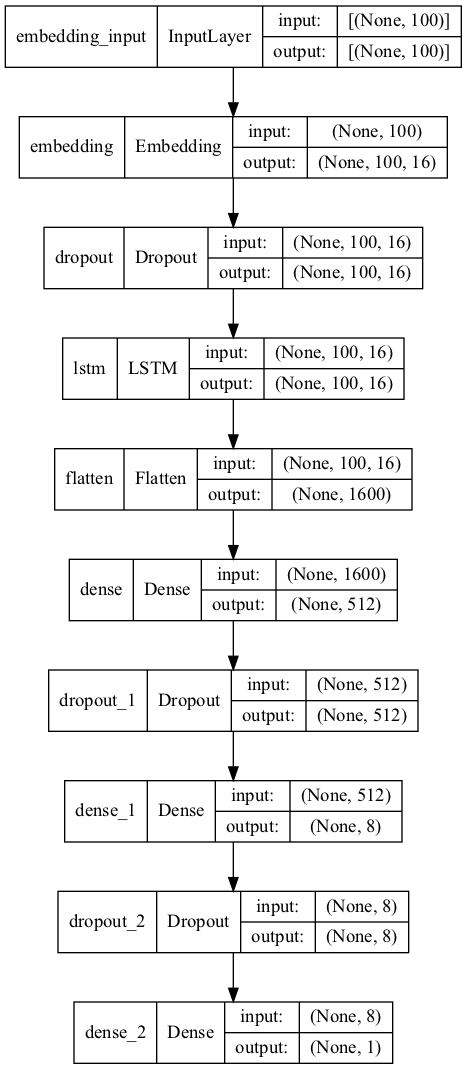

In [34]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

***
### Let's train our model
***

In [37]:
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
1335/1335 [==============================] - 379s 277ms/step - loss: 0.5118 - binary_accuracy: 0.8605 - val_loss: 0.3396 - val_binary_accuracy: 0.8873
Epoch 2/10
1335/1335 [==============================] - 353s 265ms/step - loss: 0.3827 - binary_accuracy: 0.8719 - val_loss: 0.3418 - val_binary_accuracy: 0.8830
Epoch 3/10
1335/1335 [==============================] - 356s 267ms/step - loss: 0.3699 - binary_accuracy: 0.8692 - val_loss: 0.3149 - val_binary_accuracy: 0.8911
Epoch 4/10
1335/1335 [==============================] - 358s 268ms/step - loss: 0.3653 - binary_accuracy: 0.8688 - val_loss: 0.3392 - val_binary_accuracy: 0.8827
Epoch 5/10
1335/1335 [==============================] - 504s 377ms/step - loss: 0.3638 - binary_accuracy: 0.8683 - val_loss: 0.3161 - val_binary_accuracy: 0.8923
Epoch 6/10
1335/1335 [==============================] - 363s 272ms/step - loss: 0.3629 - binary_accuracy: 0.8689 - val_loss: 0.3182 - val_binary_accuracy: 0.8879
Epoch 7/10
1335/1335 [======

In [38]:
history.history

{'loss': [0.5118113160133362,
  0.3826567232608795,
  0.36988964676856995,
  0.36531567573547363,
  0.3637793958187103,
  0.36289742588996887,
  0.3627636432647705,
  0.3619263768196106,
  0.3614709675312042,
  0.35906684398651123],
 'binary_accuracy': [0.8604788780212402,
  0.8718686103820801,
  0.8691617250442505,
  0.8687818050384521,
  0.8683338761329651,
  0.8688784241676331,
  0.8690160512924194,
  0.869493305683136,
  0.8695482015609741,
  0.8702458143234253],
 'val_loss': [0.3395880162715912,
  0.341795414686203,
  0.31486940383911133,
  0.33918678760528564,
  0.3160752058029175,
  0.31823331117630005,
  0.3294546902179718,
  0.3096591532230377,
  0.31210455298423767,
  0.3423634171485901],
 'val_binary_accuracy': [0.8872624039649963,
  0.8830227255821228,
  0.8910826444625854,
  0.8826523423194885,
  0.8922516703605652,
  0.8878911733627319,
  0.8813413381576538,
  0.893108069896698,
  0.8915489315986633,
  0.8746955990791321]}

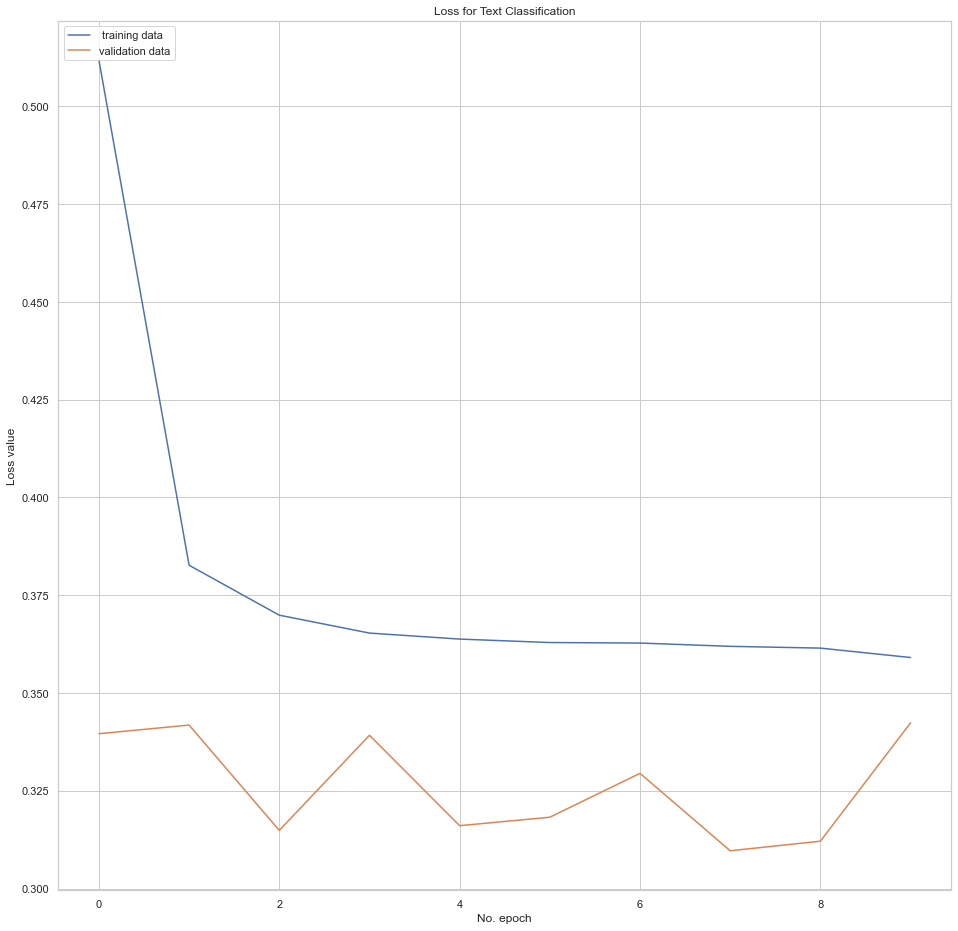

In [51]:
plt.figure(figsize=(16,16))
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

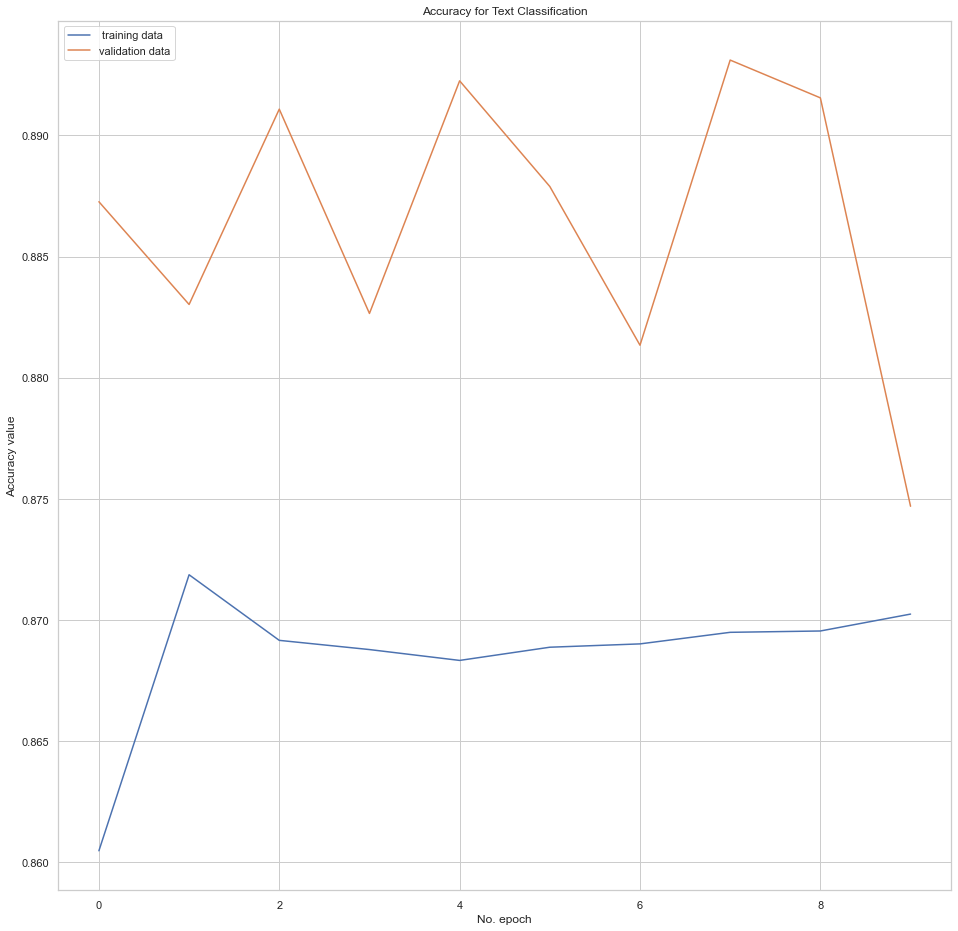

In [50]:
plt.figure(figsize=(16, 16))
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


***
### Lets save our model and tokenizer
***

In [45]:
model.save('/Users/immanuvelprathaps/Desktop/LSTM/tf_LSTM_model.h5') 
json_string = tokenizer.to_json()

In [46]:
import json
with open('/Users/immanuvelprathaps/Desktop/LSTM/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [47]:
valid_predict= model.predict(x_valid)

In [52]:
print(valid_predict[:10])

[[0.9935249 ]
 [0.910211  ]
 [0.14022955]
 [0.9861529 ]
 [0.97054845]
 [0.8549719 ]
 [0.92990625]
 [0.88980305]
 [0.96433794]
 [0.8742498 ]]


***
Code from : https://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The method was developed for operators of military radar receivers, which is why it is so named

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

***

In [53]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [54]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

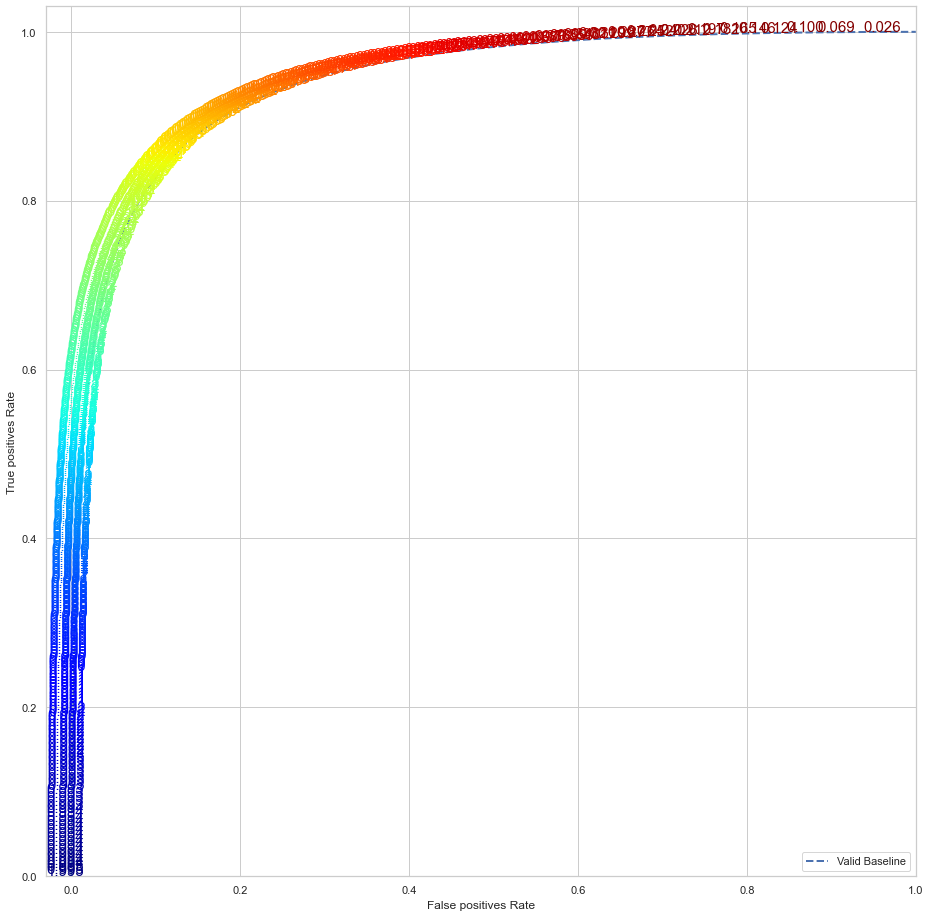

In [56]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

***
### Lets load our model and test on test data
***

In [57]:
new_model = tf.keras.models.load_model('/Users/immanuvelprathaps/Desktop/LSTM/tf_LSTM_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [58]:
with open('/Users/immanuvelprathaps/Desktop/LSTM/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [59]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [60]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)

Generate predictions for all samples


In [61]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)

/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/immanuvelprathaps/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [62]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73   1558486
           1       0.91      0.96      0.93   5591216

    accuracy                           0.89   7149702
   macro avg       0.86      0.81      0.83   7149702
weighted avg       0.89      0.89      0.89   7149702



***
### CONCLUSION
***

#### Clearly we can see that the results implies that the Dataset is IMBALANCED and so we need to improve the f1-score, because that is a better validators for Imbalanced Datasets. Let's me do that in the Next Update!

See you soon, Cheers!